In [1]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
from termcolor import colored
csv.field_size_limit(100000000)

from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import shap

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.float_format = '{:.4f}'.format

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# RandomForestClassifier
## TweetsCov19
### (Tweet content + user features)

In [2]:
path = '../data/df_tweetscov19_sample_20000.tsv'

df_tweetscov19_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'politic_pol', 'science_pol', 'moderacy_pol', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'num_posted_tweets', 'num_deleted_tweets', 'Deletion_ratio', 'Reputation', 'Is_deleted' ])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (20000, 87)


,Tweet_Id,Username,Retweets,Favorites,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,politic_pol,science_pol,moderacy_pol,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,num_posted_tweets,num_deleted_tweets,Deletion_ratio,Reputation,Is_deleted
0,1195471959783608326,9b5a75853d675346ae45e9d38e00a498,0,0,0.4201,0,6,147,0,25.7950,0,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,5.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,5.0000,10.0000,0.0000,5.0000,10.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,5.0000,5.0000,0.0000,0.0000,0.0000,5.0000,10.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.3233,True
1,1256744453722669056,4a1d843c118affc131eac1f3a6527fc3,1,0,-0.8055,0,0,83,0,68.9830,0,0.0000,0.0000,0.0000,0.0000,11.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.8800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.8800,0.0000,5.8800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.7600,0.0000,0.0000,0.0000,11.7600,0.0000,0.0000,0.0000,5.8800,17.6500,5.8800,0.0000,0.0000,0.0000,11.7600,11.7600,11.7600,0.0000,0.0000,5.8800,0.0000,0.0000,0.0000,0.0000,0.0000,5.8800,0.0000,0.0000,0.0000,637,632,0.9922,0.9953,True
2,1184288605633744896,a9490b9a1e0a5667074a3ed3eaceb4f3,1,9,-0.7650,0,0,297,1,88.4770,0,0.0000,0.0000,0.0000,0.0000,12.0700,0.0000,1.7200,0.0000,1.7200,1.7200,0.0000,0.0000,0.0000,1.7200,0.0000,1.7200,1.7200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.7200,0.0000,0.0000,5.1700,0.0000,1.7200,0.0000,1.7200,5.1700,0.0000,5.1700,1.7200,1.7200,1.7200,3.4500,1.7200,0.0000,1.7200,3.4500,12.0700,1.7200,1.7200,0.0000,3.4500,0.0000,1.7200,17.2400,5.1700,10.3400,6.9000,5.1700,10.3400,0.0000,15.5200,6.9000,1.7200,6.9000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,6.9000,1.7200,0.0000,0.0000,0.0000,7,7,1.0000,0.5282,True
3,1202228302431129600,30bf7c4fd82c57eb0acb9c52a97a0a7b,64,254,0.4767,0,0,274,0,32.3170,0,0.0000,0.0000,0.0000,0.0000,3.9200,0.0000,0.0000,0.0000,0.0000,1.9600,3.9200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.9600,0.0000,0.0000,3.9200,0.0000,0.0000,0.0000,0.0000,3.9200,1.9600,0.0000,1.9600,1.9600,5.8800,3.9200,5.8800,0.0000,3.9200,0.0000,3.9200,21.5700,1.9600,3.9200,3.9200,0.0000,0.0000,0.0000,11.7600,3.9200,13.7300,11.7600,7.8400,7.8400,0.0000,21.5700,7.8400,7.8400,0.0000,0.0000,1.9600,0.0000,1.9600,0.0000,5.8800,0.0000,3.9200,0.0000,0.0000,0.0000,6,6,1.0000,0.9964,True
4,1265647462066163712,0337e23afa1b977066317d9152c1fc2b,349,440,0.2263,2,0,219,1,53.6390,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0300,0.0000,0.0000,0.0000,3.0300,3.0300,3.0300,0.0000,3.0300,3.0300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0300,0.0000,0.0000,6.0600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,12.1200,6.0600,0.0000,0.0000,0.0000,6.0600,6.0600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0300,9.0900,9.0900,0.6471,-1.0000,0.1765,146,145,0.9932,0.8843,True


In [7]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'vader_com',
       'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability',
       'Emoji_num', 'Emoji_sent', 'politic_pol', 'science_pol', 'moderacy_pol',
       'social', 'family', 'friend', 'female', 'male', 'work', 'leisure',
       'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak',
       'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest',
       'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev',
       'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture',
       'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep',
       'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare',
       'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space',
       'time', 'user_political_polarisation', 'user_science_polarisation',
       'user_moderacy_polar

In [8]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 0, 1)
df_tweetscov19_user.tail()

,Tweet_Id,Username,Retweets,Favorites,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,politic_pol,science_pol,moderacy_pol,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,num_posted_tweets,num_deleted_tweets,Deletion_ratio,Reputation,Is_deleted
19995,1257009098492719105,b148cb1bf17504205598f9d074bcf3c9,6,12,0.6908,0,0,169,1,121.4590,1,0.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.9000,3.4500,0.0000,0.0000,10.3400,3.4500,3.4500,0.0000,3.4500,6.9000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,10.3400,13.7900,0.0000,3.4500,0.0000,0.0000,17.2400,6.9000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.9000,6.9000,0.0000,0.0000,0.0000,20,0,0.0000,0.5141,1
19996,1260997453060308992,20baa1d4e5b84e345c0a3dbd002ff20c,0,0,0.0000,0,0,140,1,42.5450,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,9.0900,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,-0.3534,1.0000,-0.8947,372,0,0.0000,0.3911,1
19997,1244816138254471169,7c6940c491382078004d2586202b052a,1,1,-0.7003,0,0,91,1,9.7000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,16.6700,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,60,0,0.0000,0.9965,1
19998,1219002080704319491,67ff79dd8d8eb3b1ee81b19d8db31277,0,0,-0.5423,0,0,159,0,85.8490,0,0.0000,0.0000,0.0000,0.0000,14.7100,0.0000,0.0000,5.8800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.9400,0.0000,0.0000,0.0000,0.0000,2.9400,0.0000,0.0000,2.9400,0.0000,0.0000,2.9400,2.9400,2.9400,2.9400,5.8800,0.0000,5.8800,0.0000,0.0000,2.9400,11.7600,0.0000,0.0000,2.9400,0.0000,5.8800,0.0000,0.0000,2.9400,14.7100,5.8800,11.7600,8.8200,2.9400,14.7100,2.9400,2.9400,0.0000,0.0000,2.9400,0.0000,0.0000,0.0000,2.9400,11.7600,5.8800,0.0000,0.0000,0.0000,5,0,0.0000,0.7501,1
19999,1229689571601985536,f2e613bb5a0de894c8fee0086b297620,9,11,0.0941,0,0,251,1,73.6450,2,1.0180,0.0000,0.0000,0.0000,4.8800,0.0000,0.0000,0.0000,0.0000,2.4400,0.0000,2.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.4400,0.0000,2.4400,0.0000,2.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.8800,2.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.8800,19.5100,4.8800,0.0000,0.0000,4.8800,9.7600,4.8800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.8800,12.2000,2.4400,-1.0000,0.0000,-1.0000,21,1,0.0476,0.4698,1


In [11]:
df_tweetscov19_user_2 = df_tweetscov19_user[features.tolist()]
#df_tweetscov19_user_2 = df_tweetscov19_user_2.drop(columns=[ 'Moderacy p.T.','Moderacy p.u.','Posted n.', 'Deleted n.', 'Deletion ratio',])
df_tweetscov19_user_2 = df_tweetscov19_user_2.drop(columns=[ 'Tweet_Id', 'Username', 'num_posted_tweets', 'num_deleted_tweets', 'Deletion_ratio'])
df = df_tweetscov19_user_2.drop('Is_deleted', axis=1)
X = df_tweetscov19_user_2.drop('Is_deleted', axis=1)
y = df_tweetscov19_user_2['Is_deleted']

y = y.astype(int)
print(X.shape)
print(y.shape)

(20000, 81)
(20000,)


In [10]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(16000, 81)
(4000, 81)
(16000,)
(4000,)


In [12]:
def fit_random_forest_clf(X,y):
    
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X,y)
    return clf

In [13]:
def test_random_forest_clf(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, y_pred))
    

In [16]:
rf_model = fit_random_forest_clf(X_train, y_train)

In [17]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_RF_Benutzer_Inhalt_alle_ohne_moderacy_2.sav'
#pickle.dump(rf_model, open(pfad_modell, 'wb'))

In [18]:
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.61475


In [20]:
def features_classifier_(df, model):

    column_feature = {}

    for i, c in enumerate(df):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = model.feature_importances_[i]
        #print(c)
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)

    df_column_feature = df_column_feature.reset_index()
    df_column_feature
    return df_column_feature

In [20]:
f_importances = features_classifier_(df, rf_model)
f_importances

,index,Feature,importance
0,80,Reputation,0.0616
1,7,readability,0.0430
2,5,Text_len,0.0426
3,2,vader_com,0.0341
4,60,prep,0.0300
5,65,verb,0.0270
6,75,space,0.0238
7,51,focuspresent,0.0236
8,13,social,0.0220
9,59,article,0.0216


In [21]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.67      0.64      2003
           1       0.63      0.56      0.59      1997

    accuracy                           0.61      4000
   macro avg       0.62      0.61      0.61      4000
weighted avg       0.62      0.61      0.61      4000



In [22]:
precision_score(y_test, y_pred)

0.6293984108967083

In [23]:
recall_score(y_test, y_pred)

0.5553329994992489

In [24]:
f1_score(y_test, y_pred)

0.590050545357808

In [21]:
def plot_confusion_matrix(y_test, y_pred, classes, titel):
    
    confusion_mx = confusion_matrix(y_test, y_pred)
    confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
    
    sns.heatmap(confusion_mx, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

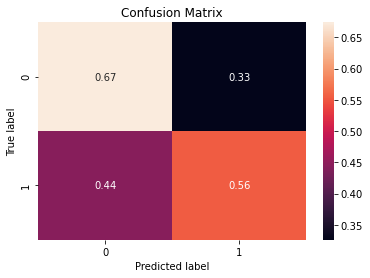

In [26]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [27]:
y_prob_test = rf_model.predict_proba(X_test)
print('Logarithmic loss für Test data', log_loss(y_test, y_prob_test))

Logarithmic loss für Test data 0.6465742758733979


In [28]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/Tweetscov19_RF_Benutzer_Inhalt_48.sav'
#rf_model = pickle.load(open(pfad_modell, 'rb'))

In [22]:
def print_cross_val_score(model, X_test, y_test):
    scores = cross_val_score(model, X_test, y_test, cv=10, scoring='precision')
    print(" percision : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X_test, y_test, cv=10, scoring='f1')
    print(" f1        : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X_test, y_test, cv=10, scoring='recall')
    print(" recall    : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

In [30]:
clf_cv = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.63 +/- 0.009
 f1        : 0.59 +/- 0.010
 recall    : 0.56 +/- 0.016


************************************************
************************************************

In [69]:
def plot_hist_Features(l_features_importances, l_features, titel):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue', 'peru', 'black', 'mediumslateblue', 'lightblue']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [70]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Reputation', 'Likes', 'Retweets', 'Political p.u.', 'Moderacy p.u.']

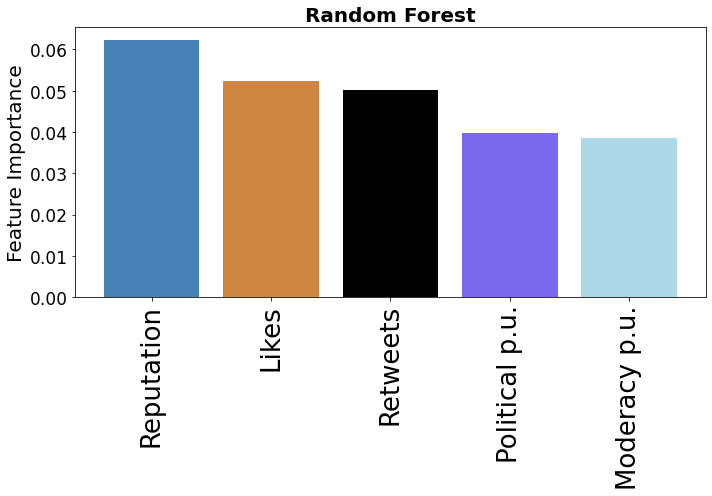

In [72]:
plot_hist_Features(l_features_importances, l_features, 'Rf_TweetsCov19_content_User(reputation)_o_moderacy_all_del')

************************************************
************************************************

## TweetsCov19
### (Content only)

In [73]:
features = df_tweetscov19_user.columns
features

features = features[2:83]
df_tweetscov19_user_2 = df_tweetscov19_user[features.tolist()]
#df_tweetscov19_user_2 = df_tweetscov19_user_2.drop(columns=[ 'Political p.u.', 'Science p.u.', 'Moderacy p.u.'])
df_tweetscov19_user_2 = df_tweetscov19_user_2.drop(columns=[ 'Moderacy p.T.'])

df = df_tweetscov19_user_2.drop('Is_deleted', axis=1)
X = df_tweetscov19_user_2.drop('Is_deleted', axis=1).values
y = df_tweetscov19_user_2['Is_deleted']

y = y.astype(int)
print(X.shape)
print(y.shape)

(20000, 79)
(20000,)


In [74]:
X_train, X_test, y_train, y_test= split_train_test_valid(X,y)

(16000, 79)
(4000, 79)
(16000,)
(4000,)


In [75]:
%%time
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.66375
Wall time: 776 ms


In [76]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_RF_Inhalt_all_ohne_moderacy.sav'
#pickle.dump(rf_model, open(pfad_modell, 'wb'))

In [77]:
f_importances = features_classifier_(df, rf_model)
f_importances

,index,Feature,importance
0,1,Likes,0.0641
1,0,Retweets,0.0565
2,5,Text l.,0.0537
3,7,Readability,0.0517
4,2,Sentiment,0.0414
5,66,Preposition,0.0382
6,71,Verb,0.0276
7,65,Article,0.0270
8,57,Focus present,0.0243
9,19,Social,0.0229


In [78]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67      2003
           1       0.67      0.64      0.66      1997

    accuracy                           0.66      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.66      0.66      0.66      4000



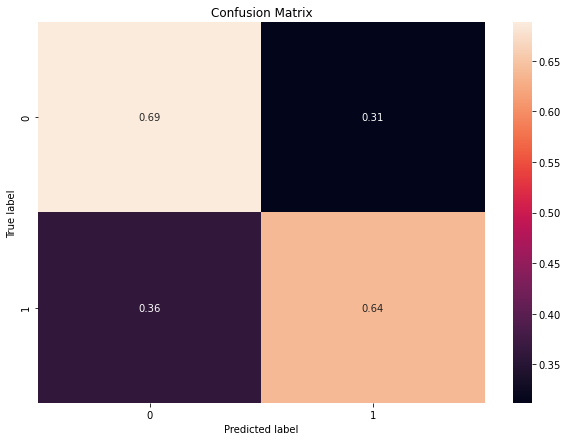

In [79]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [80]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_RF_Inhalt_all_ohne_moderacy.sav'
#rf_model = pickle.load(open(pfad_modell, 'rb'))

In [81]:
%%time
print_cross_val_score(rf_model, X_test, y_test)

 percision : 0.66 +/- 0.024
 f1        : 0.64 +/- 0.028
 recall    : 0.61 +/- 0.036
Wall time: 10.3 s


********************************************************
********************************************************

## Plot feature Imortances
### TweetCov19 (Content Only)

In [42]:
def plot_hist_Features_content_only(l_features_importances, l_features, titel):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['peru', 'black', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=18)
    ax.set_ylabel('Feature Importance', fontsize=20)
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
    fig.tight_layout()
    

    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [43]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Likes', 'Retweets', 'Text l.', 'Readability', 'Sentiment']

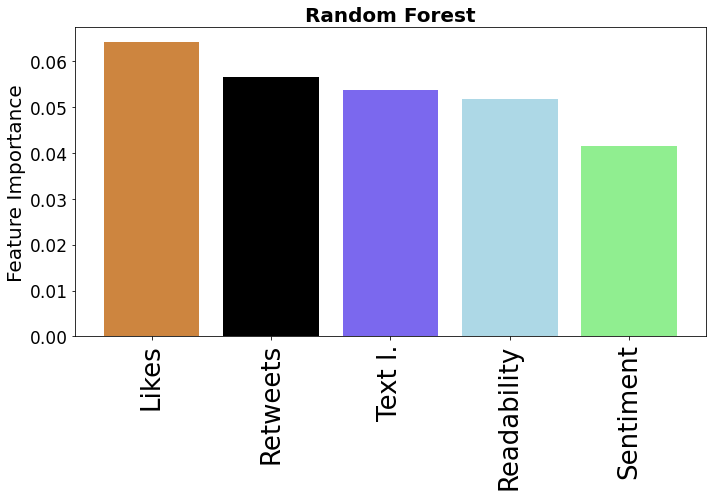

In [44]:
plot_hist_Features_content_only(l_features_importances, l_features, 'Rf_TweetsCov19_content_only_o_moderacy_all_del')

************************************************
************************************************

# Tweetskb
### (Content + User Features)

In [3]:
path = '../data/df_tweetscov19_sample_20000.tsv'

df_tweetskb_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'politic_pol', 'science_pol', 'moderacy_pol', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'num_posted_tweets', 'num_deleted_tweets', 'Deletion_ratio', 'Reputation', 'Is_deleted'])

print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (20000, 87)


,Tweet_Id,Username,Retweets,Favorites,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,politic_pol,science_pol,moderacy_pol,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,num_posted_tweets,num_deleted_tweets,Deletion_ratio,Reputation,Is_deleted
0,1195471959783608326,9b5a75853d675346ae45e9d38e00a498,0,0,0.4201,0,6,147,0,25.7950,0,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,5.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,5.0000,10.0000,0.0000,5.0000,10.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,5.0000,5.0000,0.0000,0.0000,0.0000,5.0000,10.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.3233,True
1,1256744453722669056,4a1d843c118affc131eac1f3a6527fc3,1,0,-0.8055,0,0,83,0,68.9830,0,0.0000,0.0000,0.0000,0.0000,11.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.8800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.8800,0.0000,5.8800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.7600,0.0000,0.0000,0.0000,11.7600,0.0000,0.0000,0.0000,5.8800,17.6500,5.8800,0.0000,0.0000,0.0000,11.7600,11.7600,11.7600,0.0000,0.0000,5.8800,0.0000,0.0000,0.0000,0.0000,0.0000,5.8800,0.0000,0.0000,0.0000,637,632,0.9922,0.9953,True
2,1184288605633744896,a9490b9a1e0a5667074a3ed3eaceb4f3,1,9,-0.7650,0,0,297,1,88.4770,0,0.0000,0.0000,0.0000,0.0000,12.0700,0.0000,1.7200,0.0000,1.7200,1.7200,0.0000,0.0000,0.0000,1.7200,0.0000,1.7200,1.7200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.7200,0.0000,0.0000,5.1700,0.0000,1.7200,0.0000,1.7200,5.1700,0.0000,5.1700,1.7200,1.7200,1.7200,3.4500,1.7200,0.0000,1.7200,3.4500,12.0700,1.7200,1.7200,0.0000,3.4500,0.0000,1.7200,17.2400,5.1700,10.3400,6.9000,5.1700,10.3400,0.0000,15.5200,6.9000,1.7200,6.9000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,6.9000,1.7200,0.0000,0.0000,0.0000,7,7,1.0000,0.5282,True
3,1202228302431129600,30bf7c4fd82c57eb0acb9c52a97a0a7b,64,254,0.4767,0,0,274,0,32.3170,0,0.0000,0.0000,0.0000,0.0000,3.9200,0.0000,0.0000,0.0000,0.0000,1.9600,3.9200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.9600,0.0000,0.0000,3.9200,0.0000,0.0000,0.0000,0.0000,3.9200,1.9600,0.0000,1.9600,1.9600,5.8800,3.9200,5.8800,0.0000,3.9200,0.0000,3.9200,21.5700,1.9600,3.9200,3.9200,0.0000,0.0000,0.0000,11.7600,3.9200,13.7300,11.7600,7.8400,7.8400,0.0000,21.5700,7.8400,7.8400,0.0000,0.0000,1.9600,0.0000,1.9600,0.0000,5.8800,0.0000,3.9200,0.0000,0.0000,0.0000,6,6,1.0000,0.9964,True
4,1265647462066163712,0337e23afa1b977066317d9152c1fc2b,349,440,0.2263,2,0,219,1,53.6390,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0300,0.0000,0.0000,0.0000,3.0300,3.0300,3.0300,0.0000,3.0300,3.0300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0300,0.0000,0.0000,6.0600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,12.1200,6.0600,0.0000,0.0000,0.0000,6.0600,6.0600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0300,9.0900,9.0900,0.6471,-1.0000,0.1765,146,145,0.9932,0.8843,True


In [4]:
features = df_tweetskb_user.columns
#features

In [5]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 0, 1)
df_tweetskb_user.tail()

,Tweet_Id,Username,Retweets,Favorites,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,politic_pol,science_pol,moderacy_pol,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,num_posted_tweets,num_deleted_tweets,Deletion_ratio,Reputation,Is_deleted
19995,1257009098492719105,b148cb1bf17504205598f9d074bcf3c9,6,12,0.6908,0,0,169,1,121.4590,1,0.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.9000,3.4500,0.0000,0.0000,10.3400,3.4500,3.4500,0.0000,3.4500,6.9000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,10.3400,13.7900,0.0000,3.4500,0.0000,0.0000,17.2400,6.9000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.9000,6.9000,0.0000,0.0000,0.0000,20,0,0.0000,0.5141,1
19996,1260997453060308992,20baa1d4e5b84e345c0a3dbd002ff20c,0,0,0.0000,0,0,140,1,42.5450,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,9.0900,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,-0.3534,1.0000,-0.8947,372,0,0.0000,0.3911,1
19997,1244816138254471169,7c6940c491382078004d2586202b052a,1,1,-0.7003,0,0,91,1,9.7000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,16.6700,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,60,0,0.0000,0.9965,1
19998,1219002080704319491,67ff79dd8d8eb3b1ee81b19d8db31277,0,0,-0.5423,0,0,159,0,85.8490,0,0.0000,0.0000,0.0000,0.0000,14.7100,0.0000,0.0000,5.8800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.9400,0.0000,0.0000,0.0000,0.0000,2.9400,0.0000,0.0000,2.9400,0.0000,0.0000,2.9400,2.9400,2.9400,2.9400,5.8800,0.0000,5.8800,0.0000,0.0000,2.9400,11.7600,0.0000,0.0000,2.9400,0.0000,5.8800,0.0000,0.0000,2.9400,14.7100,5.8800,11.7600,8.8200,2.9400,14.7100,2.9400,2.9400,0.0000,0.0000,2.9400,0.0000,0.0000,0.0000,2.9400,11.7600,5.8800,0.0000,0.0000,0.0000,5,0,0.0000,0.7501,1
19999,1229689571601985536,f2e613bb5a0de894c8fee0086b297620,9,11,0.0941,0,0,251,1,73.6450,2,1.0180,0.0000,0.0000,0.0000,4.8800,0.0000,0.0000,0.0000,0.0000,2.4400,0.0000,2.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.4400,0.0000,2.4400,0.0000,2.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.8800,2.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.8800,19.5100,4.8800,0.0000,0.0000,4.8800,9.7600,4.8800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.8800,12.2000,2.4400,-1.0000,0.0000,-1.0000,21,1,0.0476,0.4698,1


In [6]:
#features = features[2:94]
print(len(features))
features

87


Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'vader_com',
       'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability',
       'Emoji_num', 'Emoji_sent', 'politic_pol', 'science_pol', 'moderacy_pol',
       'social', 'family', 'friend', 'female', 'male', 'work', 'leisure',
       'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak',
       'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest',
       'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev',
       'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture',
       'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep',
       'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare',
       'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space',
       'time', 'user_political_polarisation', 'user_science_polarisation',
       'user_moderacy_polar

In [8]:
df_tweetskb_user_2 = df_tweetskb_user[features.tolist()]
df_tweetskb_user_2 = df_tweetskb_user_2.drop(columns=['Tweet_Id', 'Username', 'num_posted_tweets', 'num_deleted_tweets', 'Deletion_ratio'])
df = df_tweetskb_user_2.drop('Is_deleted', axis=1)
X = df_tweetskb_user_2.drop('Is_deleted', axis=1).values
y = df_tweetskb_user_2['Is_deleted']

y = y.astype(int)
print(X.shape)
print(y.shape)

(20000, 81)
(20000,)


In [14]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(16000, 81)
(4000, 81)
(16000,)
(4000,)


In [15]:
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.61475


In [16]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_RF_Benutzer_Inhalt_alle_ohne_moderacy.sav'
#pickle.dump(rf_model, open(pfad_modell, 'wb'))

In [17]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.67      0.64      2003
           1       0.63      0.56      0.59      1997

    accuracy                           0.61      4000
   macro avg       0.62      0.61      0.61      4000
weighted avg       0.62      0.61      0.61      4000



In [23]:
f_importances = features_classifier_(df, rf_model)
f_importances

,index,Feature,importance
0,80,Reputation,0.0616
1,7,readability,0.0430
2,5,Text_len,0.0426
3,2,vader_com,0.0341
4,60,prep,0.0300
5,65,verb,0.0270
6,75,space,0.0238
7,51,focuspresent,0.0236
8,13,social,0.0220
9,59,article,0.0216


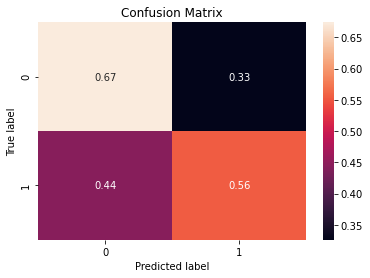

In [24]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [25]:
#pfad_model = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_RF_Benutzer_Inhalt_alle_ohne_moderacy.sav'
#rf_modell = pickle.load(open(pfad_modell, 'rb'))

In [26]:
print_cross_val_score(rf_model, X_test, y_test)

 percision : 0.61 +/- 0.035
 f1        : 0.58 +/- 0.038
 recall    : 0.55 +/- 0.045


*****************************************************
*****************************************************

## Plot feature Imortances
### Tweetkb (Content + User)

In [26]:
def plot_hist_Features_kb(l_features_importances, l_features, titel):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue','Black', 'peru', 'mediumslateblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
   #plt.legend()
    plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [27]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Reputation', 'Text l.', 'Readability', 'Sentiment', 'Verb']

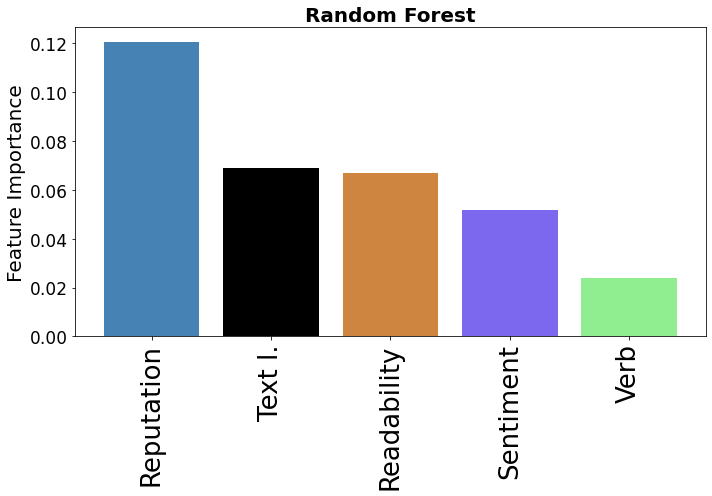

In [28]:
plot_hist_Features_kb(l_features_importances, l_features, 'Rf_Tweetskb_content_User(reputation)_2_o_moderacy_all_del')

***********************************************************************
***********************************************************************

## Tweetskb
### Content only


In [63]:
features = df_tweetskb_user.columns
features

features = features[2:83]
df_tweetskb_user_2 = df_tweetskb_user[features.tolist()]
df_tweetskb_user_2 = df_tweetskb_user_2.drop(columns=['Moderacy p.T.'])

df = df_tweetskb_user_2.drop('Is_deleted', axis=1)

X = df_tweetskb_user_2.drop('Is_deleted', axis=1).values
y = df_tweetskb_user_2['Is_deleted']

y = y.astype(int)
print(X.shape)
print(y.shape)

(20000, 79)
(20000,)


In [64]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(16000, 79)
(4000, 79)
(16000,)
(4000,)


In [65]:
%%time
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.63775
Wall time: 721 ms


In [66]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_RF_Inhalt_alle_ohne_moderacy.sav'
#pickle.dump(rf_model, open(pfad_modell, 'wb'))

In [67]:
f_importances = features_classifier_(df, rf_model)
f_importances

,index,Feature,importance
0,1,Likes,0.0624
1,7,Readability,0.0595
2,5,Text l.,0.0575
3,0,Retweets,0.0557
4,2,Sentiment,0.0477
5,66,Preposition,0.0383
6,71,Verb,0.0266
7,65,Article,0.0252
8,57,Focus present,0.0246
9,19,Social,0.0235


In [68]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65      2003
           1       0.65      0.59      0.62      1997

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000



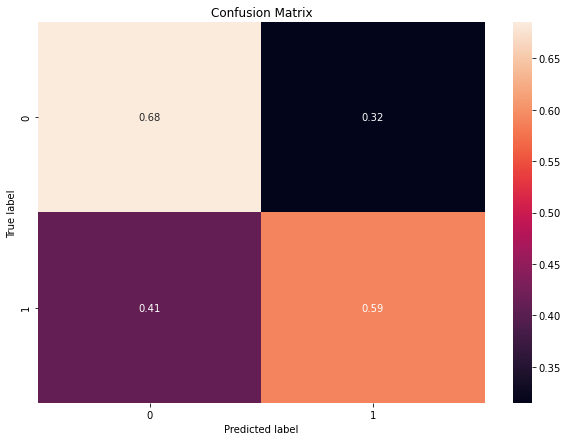

In [69]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [70]:
y_prob_test = rf_model.predict_proba(X_test)
print('Logarithmic loss für Test data', log_loss(y_test, y_prob_test))

Logarithmic loss für Test data 0.638246509731596


In [71]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_RF_Inhalt_alle_ohne_moderacy.sav'
#rf_regression = pickle.load(open(pfad_modell, 'rb'))

In [72]:
%%time
print_cross_val_score(rf_model, X_test, y_test)

 percision : 0.64 +/- 0.017
 f1        : 0.61 +/- 0.021
 recall    : 0.59 +/- 0.034
Wall time: 10.2 s


***************************************************
***************************************************

## Plot feature Imortances
### Tweetkb (Content Only )

In [73]:
def plot_hist_Features_content_only_kb(l_features_importances, l_features, titel):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['black', 'peru', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
 
    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [74]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Likes', 'Readability', 'Text l.', 'Retweets', 'Sentiment']

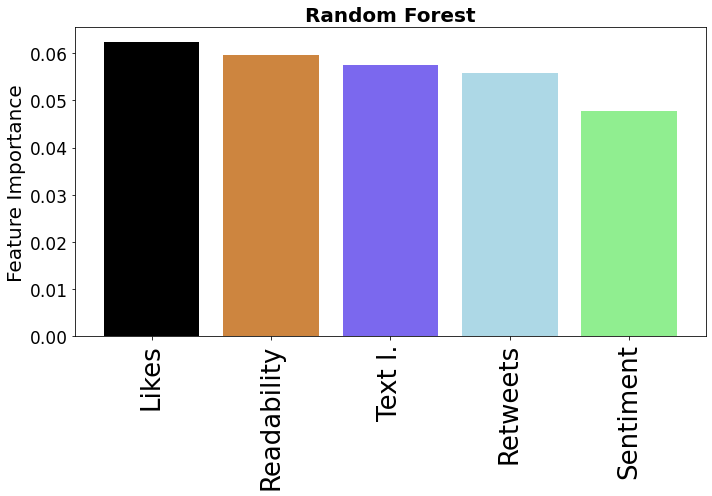

In [75]:
plot_hist_Features_content_only_kb(l_features_importances, l_features, 'Rf_Tweetskb_content_only_ohne_moderacy_alle_del')